# ChestXNet: Pneumonia Detection on Chest X-rays with Convolutional Neural Networks

In [95]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

from glob import glob
from itertools import chain
from random import sample
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, average_precision_score, accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

%matplotlib inline

## Processing of the metadata:

In [5]:
# Loading the NIH data into dataframe
# together with full image filepaths for easier manipulation

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2949,00000784_000.png,No Finding,0,784,39,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000784_000.png
82325,00020243_010.png,No Finding,10,20243,49,M,PA,2938,2991,0.143,0.143,NaN,/data/images_009/images/00020243_010.png
56818,00014125_048.png,Edema|Pneumonia,48,14125,28,M,AP,3056,2544,0.139,0.139,NaN,/data/images_007/images/00014125_048.png


In [23]:
# Splitting the "Finding Labels" columns to have a binary column for each disease
disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))

for label in disease_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1.0 if label in x else 0)

# Creating  a new column called 'pneumonia_class' for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})

# Moving the index to a separate column 'Scan_ID' for later manipulation during train/validation/test splits
all_xray_df['Scan_ID'] = all_xray_df.index
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,3
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,4


In [7]:
# Rechecking, whether there are NaN values
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
 13 

## Creating training, validation and test data:

Goals:
- no patient overlap between the sets
- imbalanced (i.e. 80/20) training and validation datasets, with appropriate weights per scan such that the model sees more non-pneumonia cases, than in the case of 50/50 split.
- imablanced test set, in which the prevalence of pneumonia cases is preserved.
    (Scans with pneumonia present consitute 1.28% of the dataset)

In [7]:
# Splitting the data into two portions:
# 1) 80% training and validation datasets
# 2) 20% test dataset
# in such a way that there is no Patient ID overlap between the sets
train_valid_inds, test_inds = next(GroupShuffleSplit(test_size=0.2, 
                                                     n_splits=1, 
                                                     random_state = 16).split(all_xray_df, groups=all_xray_df['Patient ID']))

In [9]:
train_valid_df = all_xray_df.loc[train_valid_inds]
test_df = all_xray_df.loc[test_inds]

In [10]:
# Resetting index for further split
train_valid_df.reset_index(inplace=True)
train_valid_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
0,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,3
1,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,4
2,5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,5
3,6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,6
4,7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,7


In [11]:
# Splitting the training and validation dataset into two portions:
# 1) 90% training dataset
# 2) 10% validation dataset
# in such a way that there is no Patient ID overlap between the sets
train_inds, valid_inds = next(GroupShuffleSplit(test_size=0.1, 
                                                n_splits=1, 
                                                random_state = 16).split(train_valid_df, groups=train_valid_df['Patient ID']))

In [12]:
train_df = train_valid_df.loc[train_inds]
valid_df = train_valid_df.loc[valid_inds] 

In [13]:
# Rechecking, if there is no Scan_ID overlap between sets
train_scan_ids = train_df['Scan_ID'].to_numpy()
valid_scan_ids = valid_df['Scan_ID'].to_numpy()
test_scan_ids = test_df['Scan_ID'].to_numpy()
print(f'Scan ID overlap between train and valid datasets: {np.intersect1d(train_scan_ids, valid_scan_ids)}') 
print(f'Scan ID overlap between train and test datasets: {np.intersect1d(train_scan_ids, valid_scan_ids)}') 
print(f'Scan ID overlap between valid and test datasets: {np.intersect1d(valid_scan_ids, test_scan_ids)}') 

Scan ID overlap between train and valid datasets: []
Scan ID overlap between train and test datasets: []
Scan ID overlap between valid and test datasets: []


In [14]:
# Rechecking, if there is no Patient_ID overlap between sets
train_patient_ids = train_df['Patient ID'].to_numpy()
valid_patient_ids = valid_df['Patient ID'].to_numpy()
test_patient_ids = test_df['Patient ID'].to_numpy()
print(f'Patient ID overlap between train and valid datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(valid_patient_ids))}') 
print(f'Patient ID overlap between train and test datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(test_patient_ids))}')
print(f'Patient ID overlap between valid and test datasets: {np.intersect1d(np.unique(valid_patient_ids), np.unique(test_patient_ids))}')

Patient ID overlap between train and valid datasets: []
Patient ID overlap between train and test datasets: []
Patient ID overlap between valid and test datasets: []


In [15]:
# Numer of scans in each of the set
print(f'Number of scans in train dataset: {len(train_df)}')
print(f'Number of scans in valid dataset: {len(valid_df)}')
print(f'Number of scans in test dataset: {len(test_df)}')

Number of scans in train dataset: 81008
Number of scans in valid dataset: 8682
Number of scans in test dataset: 22430


In [16]:
# Checking how much pneumonia cases are there in train and validation datasets
train_df_pneumonia_cases = len(train_df[train_df.Pneumonia==1])
valid_df_pneumonia_cases = len(valid_df[valid_df.Pneumonia==1])
test_df_pneumonia_cases = len(test_df[test_df.Pneumonia==1])
print(f'Pneumonia cases in the training set: {train_df_pneumonia_cases}.')
print(f'Pneumonia cases in the validation set: {valid_df_pneumonia_cases}.')
print(f'Pneumonia cases in the test set: {test_df_pneumonia_cases}.')
print(f'Percentage of pneumonia cases, which were assigned to the training set: {train_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')
print(f'Percentage of pneumonia cases, which were assigned to the validation set: {valid_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')
print(f'Percentage of pneumonia cases, which were assigned to the test set: {test_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')

Pneumonia cases in the training set: 1070.
Pneumonia cases in the validation set: 87.
Pneumonia cases in the test set: 274.
Percentage of pneumonia cases, which were assigned to the training set: 74.8%
Percentage of pneumonia cases, which were assigned to the validation set: 6.08%
Percentage of pneumonia cases, which were assigned to the test set: 19.1%


In [17]:
# Choosing randomly negative cases, such that the traning dataset consist of 20% positive cases.
train_df_neg_sample = 4*train_df_pneumonia_cases

train_scan_ids_pos = train_df[train_df.Pneumonia==1].index.to_numpy()
train_scan_ids_neg = train_df[train_df.Pneumonia==0].index.to_numpy()
train_scan_ids_neg_sample = np.random.choice(train_scan_ids_neg, size=train_df_neg_sample, replace=False)
train_scan_ids_pos_neg_sample = np.concatenate((train_scan_ids_pos, train_scan_ids_neg_sample))
train_df = train_df.loc[train_scan_ids_pos_neg_sample]
train_df = train_df.sample(frac=1)

In [18]:
train_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
24090,30729,00008009_039.png,Infiltration,39,8009,19,M,AP,2500,2048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,30729
88399,110430,00030079_022.png,Infiltration|Pneumonia,22,30079,16,M,AP,3056,2544,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,110430
12894,16389,00004370_000.png,No Finding,0,4370,43,F,PA,2048,2500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,16389
28797,36504,00009621_000.png,Atelectasis,0,9621,2,F,AP,2048,2500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,36504
52679,65611,00016191_023.png,Atelectasis|Pneumonia,23,16191,67,M,PA,2992,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,65611


In [19]:
# Choosing randomly negative cases, such that the validation dataset consist of 20% positive cases.
valid_df_neg_sample = 4*valid_df_pneumonia_cases

valid_scan_ids_pos = valid_df[valid_df.Pneumonia==1].index.to_numpy()
valid_scan_ids_neg = valid_df[valid_df.Pneumonia==0].index.to_numpy()
valid_scan_ids_neg_sample = np.random.choice(valid_scan_ids_neg, size=valid_df_neg_sample, replace=False)
valid_scan_ids_pos_neg_sample = np.concatenate((valid_scan_ids_pos, valid_scan_ids_neg_sample))
valid_df = valid_df.loc[valid_scan_ids_pos_neg_sample]
valid_df = valid_df.sample(frac=1)

In [9]:
train_df_pneumonia_scans = len(train_df)
valid_df_pneumonia_scans = len(valid_df)
test_df_pneumonia_scans = len(test_df)
print(f'Number of scans in the training set: {train_df_pneumonia_scans}.')
print(f'Number of scans in the validation set: {valid_df_pneumonia_scans}.')
print(f'Number of scans in the test set: {test_df_pneumonia_scans}.')

Number of scans in the training set: 5350.
Number of scans in the validation set: 435.
Number of scans in the test set: 22430.


## Comparison of demographic distributions in the training, validation and test datasets:

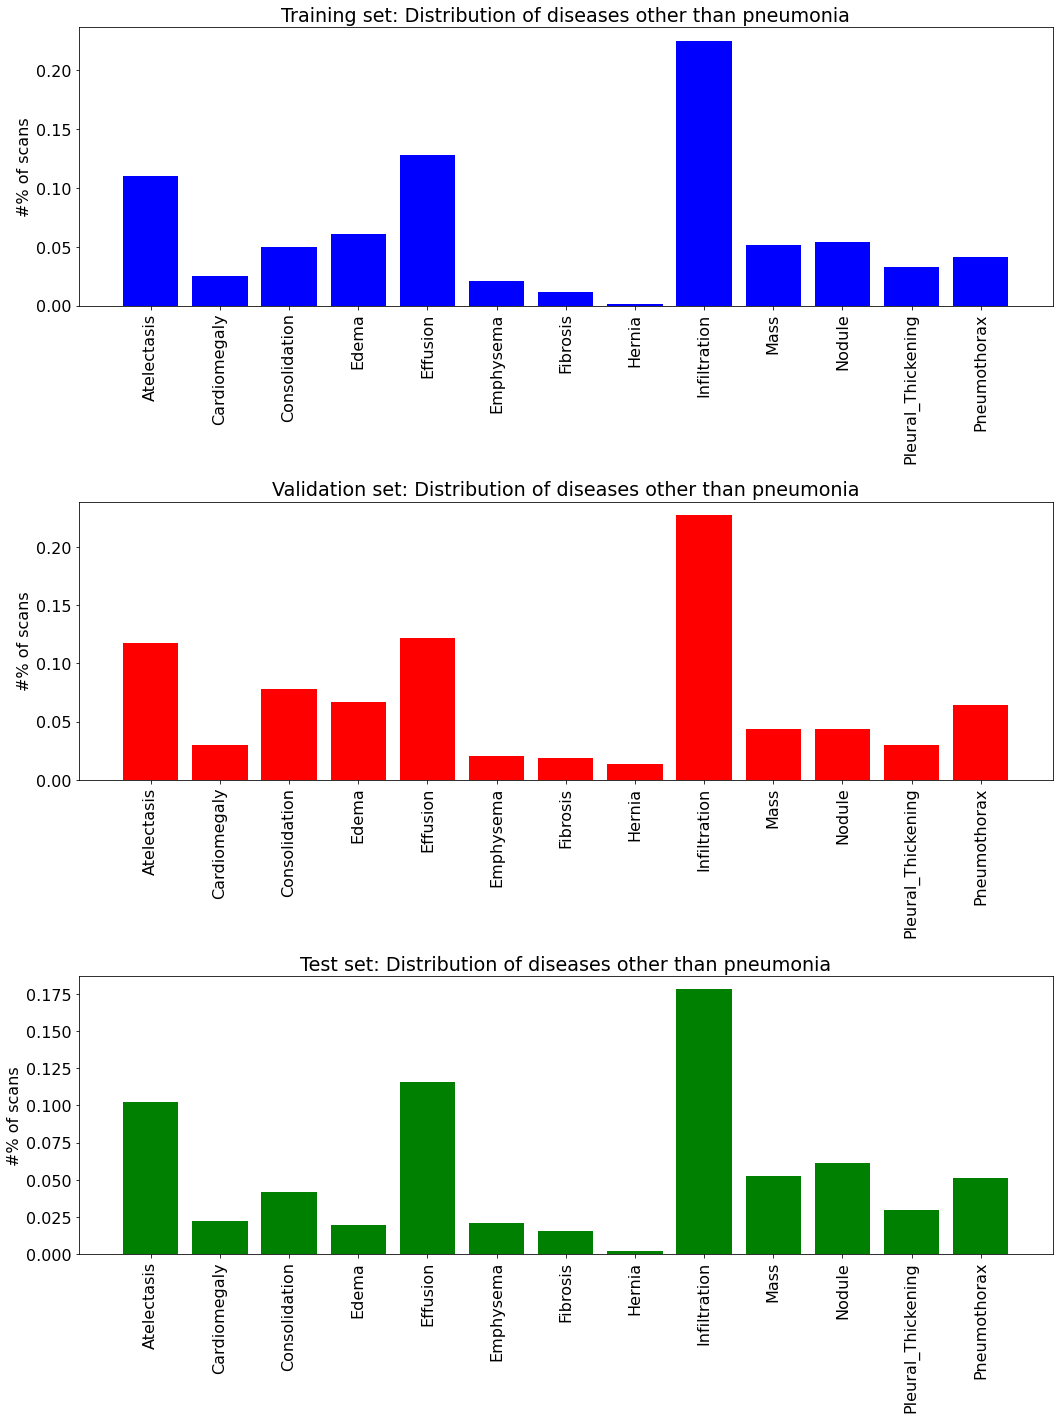

In [51]:
# Distribution of diseases other than pneumonia that are present 

#deleting "no finding" and "pneumonia" label
disease_labels_no_pneumonia = np.delete(disease_labels, [10,13]) 
disease_labels_no_pneumonia_occurance_train = train_df.loc[:,disease_labels_no_pneumonia].sum()/len(train_df.loc[:,disease_labels_no_pneumonia])
disease_labels_no_pneumonia_occurance_valid = valid_df.loc[:,disease_labels_no_pneumonia].sum()/len(valid_df.loc[:,disease_labels_no_pneumonia])
disease_labels_no_pneumonia_occurance_test = test_df.loc[:,disease_labels_no_pneumonia].sum()/len(test_df.loc[:,disease_labels_no_pneumonia])

fig, ax = plt.subplots(3,1, figsize=(15,20))
plt.rcParams.update({'font.size': 16})
ax[0].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_train, color='blue')
ax[0].set_title("Training set: Distribution of diseases other than pneumonia")
ax[0].set_ylabel('#% of scans')
ax[0].set_xticklabels(disease_labels_no_pneumonia, rotation=90)

ax[1].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_valid, color='red')
ax[1].set_title("Validation set: Distribution of diseases other than pneumonia")
ax[1].set_ylabel('#% of scans')
ax[1].set_xticklabels(disease_labels_no_pneumonia, rotation=90)

ax[2].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_test, color='green')
ax[2].set_title("Test set: Distribution of diseases other than pneumonia")
ax[2].set_ylabel('#% of scans')
ax[2].set_xticklabels(disease_labels_no_pneumonia, rotation=90)
fig.tight_layout()

- The biggest difference is in occurance of Edema

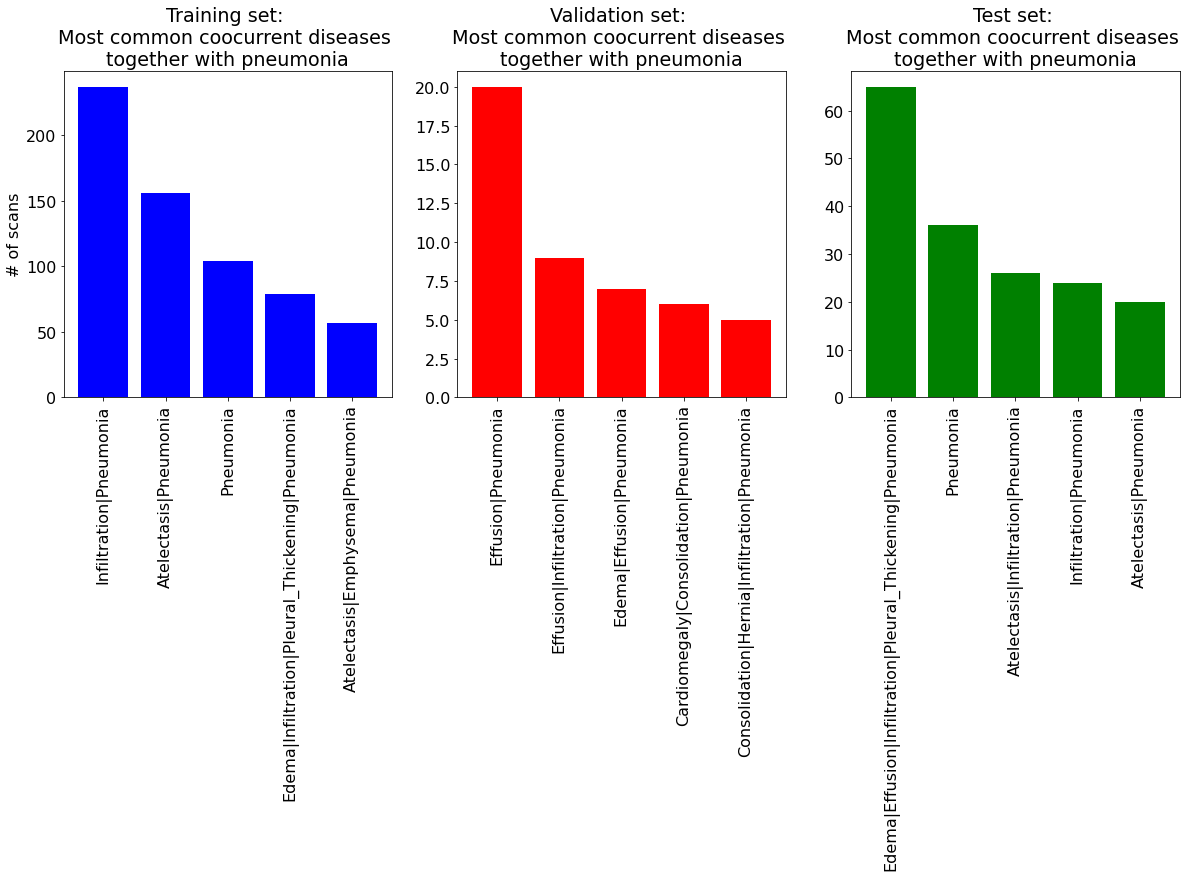

In [63]:
# Distribution of co-ocurrent diseases together with pneumonia

fig, ax = plt.subplots(1,3, figsize=(20,6))
plt.rcParams.update({'font.size': 16})

ax[0].bar(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], 
          train_df[train_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='blue')
ax[0].set_title("Training set: \nMost common coocurrent diseases \ntogether with pneumonia")
ax[0].set_xticklabels(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)
ax[0].set_ylabel('# of scans')

ax[1].bar(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], 
          valid_df[valid_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='red')
ax[1].set_title("Validation set: \nMost common coocurrent diseases \ntogether with pneumonia")
ax[1].set_xticklabels(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)

ax[2].bar(test_df[test_df.Pneumonia==1]['Finding Labels'][0:5], 
          test_df[test_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='green')
ax[2].set_title("Test set: \nMost common coocurrent diseases \ntogether with pneumonia")
ax[2].set_xticklabels(test_df[test_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)

plt.show()

- In all datasets Pneumonia most frequently is present on a scan together with other diseases, whose combination varies between datasets

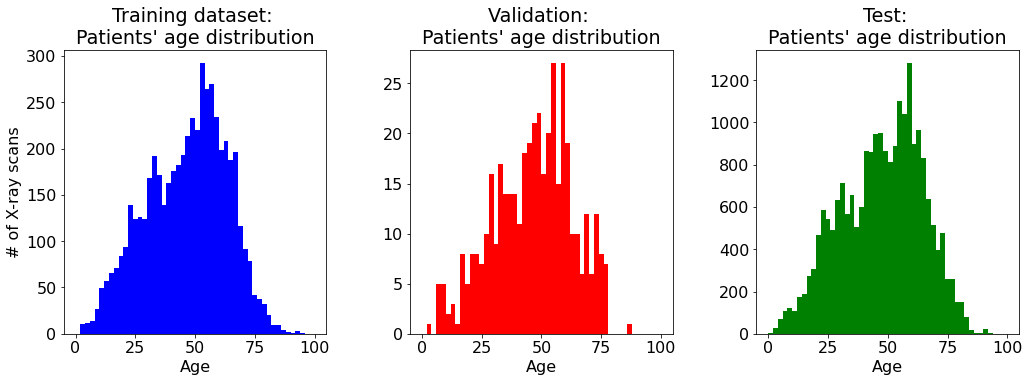

In [55]:
# Distribution of age 

fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.rcParams.update({'font.size': 16})
ax[0].hist(train_df['Patient Age'], bins=50, range=(0,100), color='blue')
ax[0].set_title("Training dataset: \nPatients' age distribution")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('# of X-ray scans')
ax[1].hist(valid_df['Patient Age'], bins=50, range=(0,100), color='red')
ax[1].set_title("Validation: \nPatients' age distribution")
ax[1].set_xlabel('Age')
ax[2].hist(test_df['Patient Age'], bins=50, range=(0,100), color='green')
ax[2].set_title("Test: \nPatients' age distribution")
ax[2].set_xlabel('Age')
fig.tight_layout(pad=2.0)
plt.show()

- Age distribution is similar across datsets. The distribution in the validation dataset is noisy, as it consists of the smallest amount of scans.

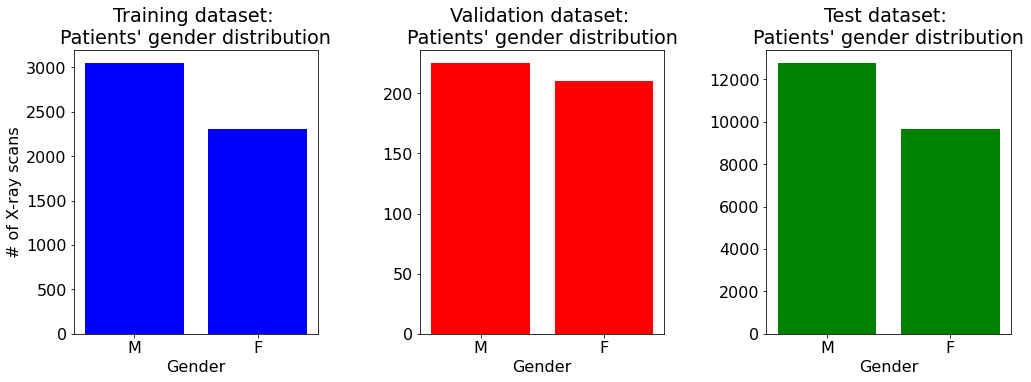

In [58]:
# Distribution of patients' gender 

fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.rcParams.update({'font.size': 16})

ax[0].bar(train_df['Patient Gender'].unique(),train_df['Patient Gender'].value_counts(), color='blue')
ax[0].set_title("Training dataset: \nPatients' gender distribution")
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(valid_df['Patient Gender'].unique(), valid_df['Patient Gender'].value_counts(), color='red')
ax[1].set_title("Validation dataset: \nPatients' gender distribution")
ax[1].set_xlabel('Gender')

ax[2].bar(test_df['Patient Gender'].unique(), test_df['Patient Gender'].value_counts(), color='green')
ax[2].set_title("Test dataset: \nPatients' gender distribution")
ax[2].set_xlabel('Gender')

fig.tight_layout(pad=2.0)
plt.show()

In [26]:
M_F_ratio_train = train_df['Patient Gender'].value_counts()[0] / train_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Training dataset {M_F_ratio_train:.2}.')

M_F_ratio_valid = valid_df['Patient Gender'].value_counts()[0] / valid_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Validation dataset {M_F_ratio_valid:.2}.')

M_F_ratio_test = test_df['Patient Gender'].value_counts()[0] / test_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Test dataset {M_F_ratio_test:.2}.')

M/F ratio: Training dataset 1.3.
M/F ratio: Validation dataset 1.1.
M/F ratio: Test dataset 1.3.


- The training and the test set have very similar Male/Female ratio.
- The Male/Female ratio in the validation set is slightly lower.

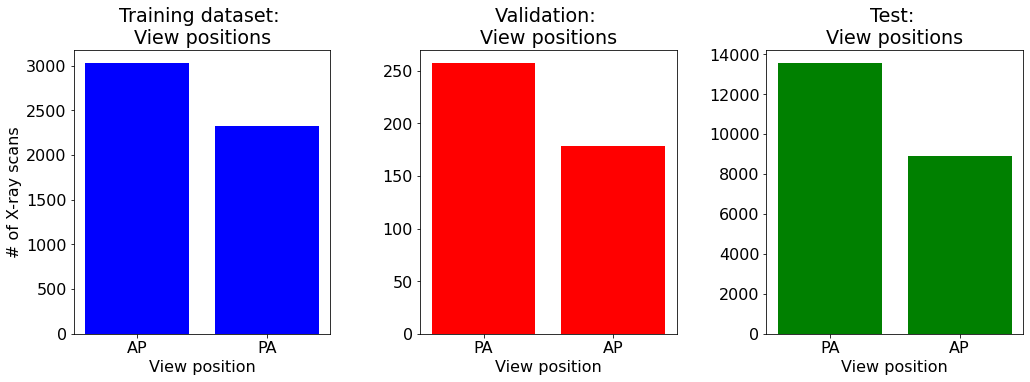

In [59]:
# Distribution of view position in the train and the validaton set
fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.rcParams.update({'font.size': 16})
ax[0].bar(train_df['View Position'].unique(),train_df['View Position'].value_counts(), color='blue')
ax[0].set_title("Training dataset: \nView positions")
ax[0].set_xlabel('View position')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(valid_df['View Position'].unique(), valid_df['View Position'].value_counts(), color='red')
ax[1].set_title("Validation: \nView positions")
ax[1].set_xlabel('View position')

ax[2].bar(test_df['View Position'].unique(), test_df['View Position'].value_counts(), color='green')
ax[2].set_title("Test: \nView positions")
ax[2].set_xlabel('View position')

fig.tight_layout(pad=2.0)
plt.show()

In [28]:
PA_AP_ratio_train = train_df['View Position'].value_counts()[0] / train_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Training dataset {PA_AP_ratio_train:.2}.')

PA_AP_ratio_valid = valid_df['View Position'].value_counts()[0] / valid_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Validation dataset {PA_AP_ratio_valid:.2}.')

PA_AP_ratio_test = test_df['View Position'].value_counts()[0] / test_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Test dataset {PA_AP_ratio_test:.2}.')

PA/AP ratio: Training dataset 1.3.
PA/AP ratio: Validation dataset 1.4.
PA/AP ratio: Test dataset 1.5.


- The AP/PA rations are similar across datasets.

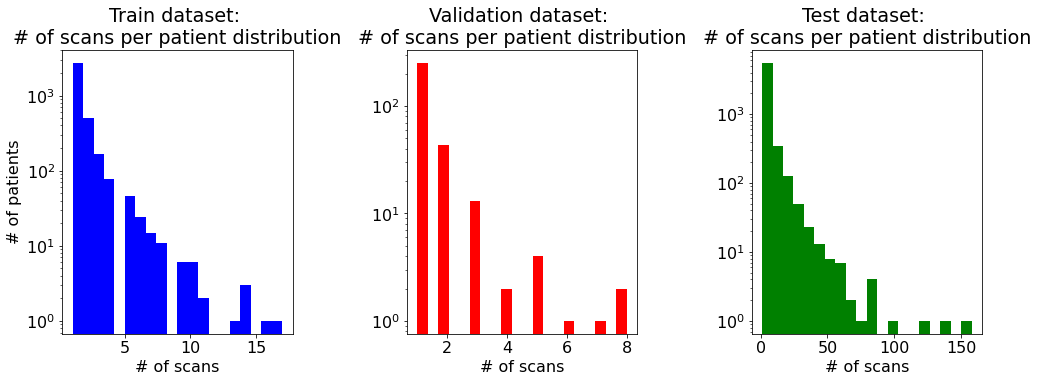

In [60]:
# Distribution of number of scans per patient in the train and the validaton set
fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.rcParams.update({'font.size': 16})

ax[0].hist(train_df['Patient ID'].value_counts(), bins=20, log=True, color='blue')
ax[0].set_title("Train dataset: \n# of scans per patient distribution")
ax[0].set_xlabel('# of scans')
ax[0].set_ylabel('# of patients')

ax[1].hist(valid_df['Patient ID'].value_counts(), bins=20, log=True, color='red')
ax[1].set_title("Validation dataset: \n# of scans per patient distribution")
ax[1].set_xlabel('# of scans')

ax[2].hist(test_df['Patient ID'].value_counts(), bins=20, log=True, color='green')
ax[2].set_title("Test dataset: \n# of scans per patient distribution")
ax[2].set_xlabel('# of scans')

fig.tight_layout(pad=2.0)
plt.show()

## Introduction of weights

- The distributions of number of scans per patiens are very different across datasets, resulting from sub-sampling of pneumonia negative cases in the training and validation datsets and of a small size of the validation dataset.

In [30]:
# Train_df: Introduction of weights
w_positive_train = (len(train_df) - train_df_pneumonia_cases) / len(train_df)
w_negative_train = train_df_pneumonia_cases / len(train_df)
train_df['weight'] = train_df['Pneumonia'].apply(lambda x: w_positive_train if x==1.0 else w_negative_train)
train_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID,weight
24090,30729,00008009_039.png,Infiltration,39,8009,19,M,AP,2500,2048,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,30729,0.2
88399,110430,00030079_022.png,Infiltration|Pneumonia,22,30079,16,M,AP,3056,2544,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,110430,0.8
12894,16389,00004370_000.png,No Finding,0,4370,43,F,PA,2048,2500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,16389,0.2
28797,36504,00009621_000.png,Atelectasis,0,9621,2,F,AP,2048,2500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,36504,0.2
52679,65611,00016191_023.png,Atelectasis|Pneumonia,23,16191,67,M,PA,2992,2991,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,65611,0.8


In [31]:
# Valid_df: Introduction of weights
w_positive_valid = (len(valid_df) - valid_df_pneumonia_cases) / len(valid_df)
w_negative_valid = valid_df_pneumonia_cases / len(valid_df)
valid_df['weight'] = valid_df['Pneumonia'].apply(lambda x: w_positive_valid if x==1.0 else w_negative_valid)
valid_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID,weight
68316,85556,00021092_003.png,Atelectasis|Pneumothorax,3,21092,47,M,PA,2992,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Negative,85556,0.2
49925,62140,00015376_021.png,Effusion|Pneumonia,21,15376,60,F,AP,2500,2048,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,62140,0.8
5941,7556,00001985_000.png,No Finding,0,1985,55,M,PA,2021,2021,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,7556,0.2
6025,7669,00002004_003.png,No Finding,3,2004,54,M,PA,2048,2500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,7669,0.2
17713,22726,00006008_010.png,Effusion|Infiltration|Pneumonia,10,6008,74,M,AP,2500,2048,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,22726,0.8


In [32]:
print(f'Training set: pneumonia positive weight {w_positive_train:.3}')
print(f'Training set: pneumonia negative weight {w_negative_train:.3}')
print(f'Validation set: pneumonia positive weight {w_positive_valid:.3}')
print(f'Validation set: pneumonia negative weight {w_negative_valid:.3}')

Training set: pneumonia positive weight 0.8
Training set: pneumonia negative weight 0.2
Validation set: pneumonia positive weight 0.8
Validation set: pneumonia negative weight 0.2


## Saving and loading of training, validation and test datasets:

In [33]:
# Saving train_df, valid_df and test_df
train_df.to_pickle('train_df.pkl')
valid_df.to_pickle('valid_df.pkl')
test_df.to_pickle('test_df.pkl')

In [2]:
# Loading train_df, valid_df and test_df
train_df = pd.read_pickle('train_df.pkl')
valid_df = pd.read_pickle('valid_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

## Training, validation and test generators

In [3]:
# Functions for data augumantation for training, validation and test generator

def image_augmentation_train(rescale=1./255.0, height_shift_range=0.1, width_shift_range=0.1, 
                                rotation_range=2, zoom_range=0.01):
    
    """Function returing training image data generator with normalized and augumented images"""
    
    train_idg = ImageDataGenerator(rescale = rescale,
                            height_shift_range = height_shift_range,
                            width_shift_range = width_shift_range,
                            rotation_range = rotation_range,
                            zoom_range = zoom_range)
    
    return train_idg



def image_augmentation_valid(rescale=1./255.0):
    
    """Function returing validation image data generator with normalized images"""
       
    valid_idg = ImageDataGenerator(rescale = rescale)
    
    return valid_idg


def image_augmentation_test(rescale=1./255.0):
    
    """Function returing test image data generator with normalized images"""
       
    test_idg = ImageDataGenerator(rescale = rescale)
    
    return test_idg

In [4]:
def make_train_gen(train_idg, train_df, directory=None, x_col='path', y_col='pneumonia_class',weight_col = 'weight', 
                  class_mode='binary', target_size=(224, 224), batch_size=64):
    
    """Function returing training generator, reading the image paths to load from dataframe"""
    
    train_gen = train_idg.flow_from_dataframe(dataframe = train_df, 
                                         directory=directory,
                                         x_col = x_col,
                                         y_col = y_col,
                                         weight_col = weight_col,    
                                         class_mode = class_mode,
                                         target_size = target_size, 
                                         batch_size = batch_size)     

    return train_gen




def make_valid_gen(valid_idg, valid_df, directory=None, x_col='path', y_col='pneumonia_class',weight_col = 'weight',
                  class_mode='binary', target_size=(224, 224), batch_size=64):
    
    """Function returing validation generator, reading the image paths to load from dataframe"""
    
    valid_gen = valid_idg.flow_from_dataframe(dataframe = valid_df, 
                                             directory = directory, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             weight_col = weight_col, 
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size) 
    
    return valid_gen


def make_test_gen(test_idg, test_df, directory=None, x_col='path', y_col='pneumonia_class',
                  class_mode='binary', target_size=(224, 224), batch_size=64):
    
    """Function returing validation generator, reading the image paths to load from dataframe"""
    
    test_gen = test_idg.flow_from_dataframe(dataframe = test_df, 
                                             directory = directory, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             shuffle = False,
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size) 
    
    return test_gen

Found 5350 validated image filenames belonging to 2 classes.


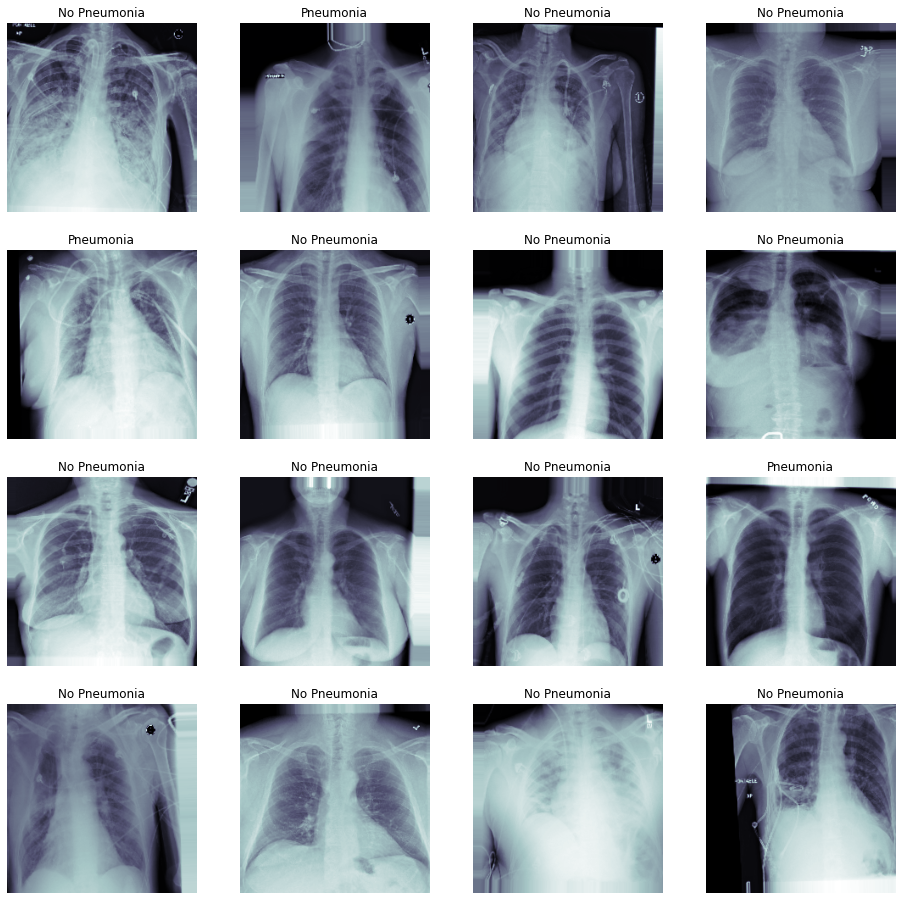

In [7]:
# Looking at some examples of our augmented training data  
# to understand the extent to which data is being manipulated prior to training, 

train_idg = image_augmentation_train()
train_gen = make_train_gen(train_idg, train_df)

t_x, t_y, t_weight= next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [5]:
# Pulling a single large batch of random validation data for testing after each epoch:
valid_gen = make_valid_gen(image_augmentation_valid(), valid_df)
valX, valY, valWeight = valid_gen.next()

test_gen = make_test_gen(image_augmentation_test(), test_df)
testX, tesyY = test_gen.next()

Found 435 validated image filenames belonging to 2 classes.
Found 22430 validated image filenames belonging to 2 classes.


In [73]:
# Train generator: accessing the order of the classes in order to make correct weight assigment in fit_generator
train_gen.class_indices

{'Negative': 0, 'Positive': 1}

## Fuctions for model building and evaluation

In [35]:
# Loading VGG16 pre-trained model and displaying its layers

model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [70]:
def load_pretrained_model(pretrained_model=VGG16, weights='imagenet', transfer_layer='block5_pool', 
                          transfer_layer_idx=18):
    
    """Function loading pre-trained model with defined weights and defined transfer layer"""
    
    model = pretrained_model(include_top=True, weights=weights)
    transfer_layer = model.get_layer(transfer_layer)
    pretrained_model = Model(inputs = model.input, outputs = model.output) 
    
    # freezing layers till transfer_layer
    for layer in pretrained_model.layers[0:transfer_layer_idx]:
        layer.trainable = False
    
    # rechecking, if the freezeing was performed correctly
    print('Pre-trained model layers and their trainability')
    for layer in pretrained_model.layers:
        print(layer.name, layer.trainable)
    
    return pretrained_model


In [71]:
def build_model(pretrained_model, lr=0.0001, loss = 'binary_crossentropy', metrics = ['binary_accuracy'], dropout=0.5):
    
    """Function builing a model by attaching layers after the pre-trained model"""
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=lr)
    loss = loss
    metrics = metrics 
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model

In [55]:
def plot_history(history_df):
    
    N = len(history_df)
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    plt.rcParams.update({'font.size':16})
    
    ax[0].plot(np.arange(0, N), history_df["loss"], label="train loss", color='blue')
    ax[0].plot(np.arange(0, N), history_df["val_loss"], label="valid loss", color='red')
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("# of epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    ax[1].plot(np.arange(0, N), history_df["binary_accuracy"], label="train acc", color='blue')
    ax[1].plot(np.arange(0, N), history_df["val_binary_accuracy"], label="valid acc", color='red')
    ax[1].set_title("Training and validation accuracy")
    ax[1].set_xlabel("# of epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    
    fig.tight_layout(pad=3.0)
    plt.show()
    
    
def make_GT_pred_df(GT_array, pred_array):
    GT_pred_df = pd.DataFrame(GT_array, columns=['Ground_truth'])
    GT_pred_df['Pred'] = pred_array
    display(GT_pred_df.head())
    
    return GT_pred_df

    
def plot_prediction_distribution(pred_array):
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Prediction: probability of pneumonia')
    plt.ylabel('# number of scans')
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')

In [86]:
def plot_AUROC(GT_array, pred_array):
    
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    fpr, tpr, thresholds = roc_curve(GT_array, pred_array)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend()
    plt.show()
    
    return fpr, tpr, thresholds
    

def plot_precision_recall_curve(GT_array, pred_array):
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(GT_array,pred_array)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    return precision, recall, thresholds

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

## Training model based on VGG16:

### Model 1 (VGG16-based)

In [53]:
#Adding checkpoints to the model,
## Saving the 'best' version of the model by comparing it to previous epochs of training
## Setting 'patience' parameter to 20: the model will train for 20 epochs without seeing improvement before quitting
## The training loss is monitored, as the validation loss is unstable due to small number of scans per batch used for 
 # monitoring model performance (bigger batch was not possible to allocate on the GPU)

weight_path_1 ="{}_model_1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_1, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode= 'min', 
                      patience=20)

callbacks_list = [checkpoint, early]

In [56]:
# Setting the transfer layer in the VGG16 model to block4_pool
# Displaying the trainability of the layers 
## True: layer is trainable (i.e. unfrozen)
## False: layer is not trainable (i.e. frozen)

model_1_pretrained = load_pretrained_model(transfer_layer='block4_pool', 
                          transfer_layer_idx=14)

# Builing the model on the basis of the pretrained model
model_1 = build_model(model_1_pretrained, lr=0.001)

Pre-trained model layers and their trainability
input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
predictions True


In [57]:
# Training the model for 30 epochs

history_1 = model_1.fit_generator(train_gen, 
                          validation_data = (valX, valY),
                          class_weight = [w_negative_train, w_positive_train],
                          epochs = 30, 
                          callbacks = callbacks_list)

# Creating dataframe with training history and saving it to *pkl
history_1_df = pd.DataFrame(history_1.history)
history_1_df.to_pickle('history_1_df.pkl')

# Saving the model to *json
model_1_json = model_1.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_1_json)

Epoch 1/30
84/84 [==============================] - 147s 2s/step - loss: 0.2224 - binary_accuracy: 0.5359 - val_loss: 0.7249 - val_binary_accuracy: 0.1406

Epoch 00001: loss improved from inf to 0.22219, saving model to xray_class_model_1.best.hdf5
Epoch 2/30
84/84 [==============================] - 151s 2s/step - loss: 0.2222 - binary_accuracy: 0.4658 - val_loss: 0.6745 - val_binary_accuracy: 0.8594

Epoch 00002: loss improved from 0.22219 to 0.22210, saving model to xray_class_model_1.best.hdf5
Epoch 3/30
84/84 [==============================] - 153s 2s/step - loss: 0.2219 - binary_accuracy: 0.5056 - val_loss: 0.7263 - val_binary_accuracy: 0.1406

Epoch 00003: loss improved from 0.22210 to 0.22194, saving model to xray_class_model_1.best.hdf5
Epoch 4/30
84/84 [==============================] - 150s 2s/step - loss: 0.2223 - binary_accuracy: 0.4865 - val_loss: 0.7155 - val_binary_accuracy: 0.1406

Epoch 00004: loss did not improve from 0.22194
Epoch 5/30
84/84 [========================

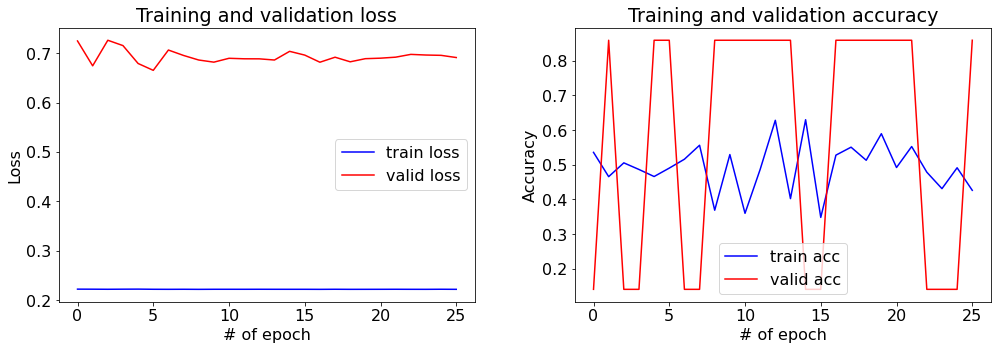

In [31]:
history_1_df = pd.read_pickle('history_1_df.pkl')
plot_history(history_1_df)

- The training loss and the training accuracy oscillated around the same level throughout the training, meaning that the model did not learn.
- No further evaluation of the model will be performed.
- In the next step ResNet50-based model will be trained.

## Training models based on ResNet50:

In [72]:
# Building models on the basis of ResNet50 model

# new imports
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import model_from_json
from keras.initializers import glorot_uniform

# Those imports are rewritten to work with ResNet50 pre-trained model
# (from keras to tensorflow.keras, not to get errors)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [40]:
ResNet50().summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Model 2 (ResNet50-based)

In [73]:
# Model with transfer layer 'conv5_block3_3_conv' and learning rate 1E-3
weight_path_2 ="{}_model_2.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_2, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

model_2_pretrained = load_pretrained_model(pretrained_model=ResNet50, transfer_layer='conv5_block3_3_conv', transfer_layer_idx=171)
model_2 = build_model(model_2_pretrained, lr=0.001)

102973440/102967424 [==============================] - 2s 0us/step
Pre-trained model layers and their trainability
input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
co

In [42]:
history_2 = model_2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

history_2_df = pd.DataFrame(history_2.history)
history_2_df.to_pickle('history_2_df.pkl')

model_2_json = model_2.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_2_json)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 84 steps, validate on 64 samples
Epoch 1/30
83/84 [============================>.] - ETA: 1s - loss: 0.2168 - binary_accuracy: 0.5755
Epoch 00001: loss improved from inf to 0.21743, saving model to xray_class_model_2.best.hdf5
84/84 [==============================] - 147s 2s/step - loss: 0.2173 - binary_accuracy: 0.5751 - val_loss: 0.6716 - val_binary_accuracy: 0.7812
Epoch 2/30
83/84 [============================>.] - ETA: 1s - loss: 0.2128 - binary_accuracy: 0.5959
Epoch 00002: loss improved from 0.21743 to 0.21268, saving model to xray_class_model_2.best.hdf5
84/84 [==============================] - 133s 2s/step - loss: 0.2127 - binary_accuracy: 0.5964 - val_loss: 0.7863 - val_binary_accuracy: 0.2188
Epoch 3/30
83/84 [============================>.] - ETA: 1s - loss: 0.2110 - binary_accuracy: 0.6317
Epoch 00003: loss improved from 0.21268 to 0.21067, saving model to xray_cl

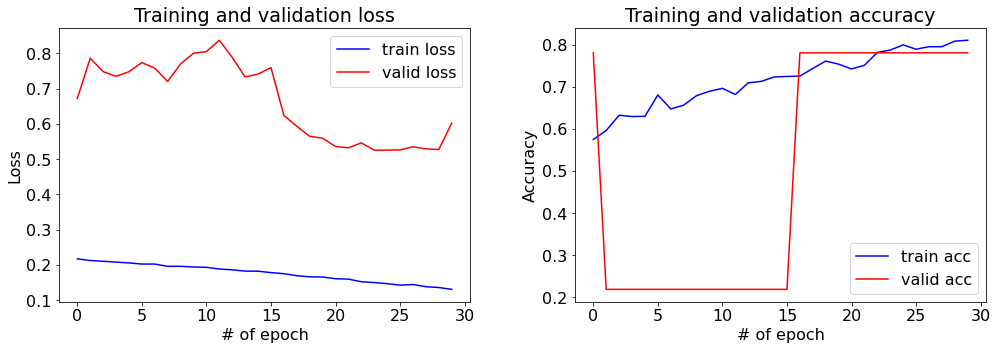

In [32]:
history_2_df = pd.read_pickle('history_2_df.pkl')
plot_history(history_2_df)

- The training and validation losses decrease during training, the training accuracy increases, meaning that the model learned.
- The validation loss is higher than the training loss, which is usually sign of overfitting. However, due to the small size of the validation batch, no meaningful conclusions can be drawn. Ideally the whole validation dataset shall be used for model performance monitoring during training (this was not possible to allocate on the GPU). Because of that also the validation accuracy is not meaningful.

In [9]:
# Loading the model and the weights
with open('model_2.json', 'r') as json_file:
    model_2 = json_file.read()

model_2 = model_from_json(model_2)
model_2.load_weights('xray_class_model_2.best.hdf5')

In [10]:
# Generating predictions for test dataset  and saving them as numpy array together with ground truth
pred_Y_2 = model_2.predict_generator(test_gen, steps=len(test_df)/64, verbose = True)
np.save("pred_Y_2.npy", pred_Y_2)
np.save("ground_truth_2.npy", test_gen.labels)

Instructions for updating:
Please use Model.predict, which supports generators.
351/350 [==============================] - 382s 1s/step


In [50]:
# Loading the predictions and ground truth from numpy array
pred_Y_2 = np.load("pred_Y_2.npy")
ground_truth_2 = np.load("ground_truth_2.npy")
GT_pred_Y_2_df = make_GT_pred_df(ground_truth_2, pred_Y_2)
GT_pred_Y_2_df.to_pickle("GT_pred_Y_2_df.pkl")

,Ground_truth,Pred
0,0,0.083591
1,0,0.083884
2,0,0.090737
3,0,0.090424
4,0,0.090008


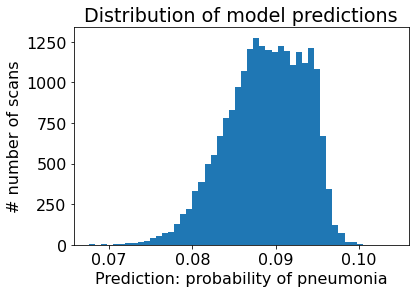

Model prediction min: 0.0676
Model prediction max: 0.104


In [56]:
# Plotting the prediction distribution
plot_prediction_distribution(pred_Y_2)

- In all test cases the model is between 6.7% and 10.4% sure that the scan is pneumonia positive

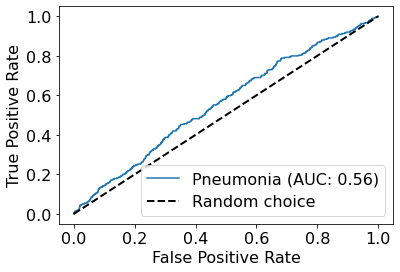

In [67]:
fpr_2, tpr_2, thresholds_auroc_2 = plot_AUROC(ground_truth_2, pred_Y_2)

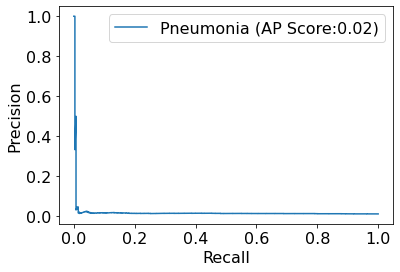

In [68]:
precision_2, recall_2, thresholds_pr_2 = plot_precision_recall_curve(ground_truth_2, pred_Y_2)

### Model 3 (ResNet50-based)

- Unfreezing 13 more layers

In [45]:
weight_path_3 ="{}_model_3.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_3, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

model_3_pretrained = load_pretrained_model(pretrained_model=ResNet50, transfer_layer='conv5_block2_2_conv', transfer_layer_idx=158)
model_3 = build_model(model_3_pretrained, lr=0.001)

102973440/102967424 [==============================] - 4s 0us/step
Pre-trained model layers and their trainability
input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
co

In [46]:
history_3 = model_3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

history_3_df = pd.DataFrame(history_3.history)
history_3_df.to_pickle('history_3_df.pkl')

model_3_json = model_3.to_json()
with open("model_3.json", "w") as json_file:
    json_file.write(model_3_json)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 84 steps, validate on 64 samples
Epoch 1/30
83/84 [============================>.] - ETA: 1s - loss: 0.2182 - binary_accuracy: 0.5662
Epoch 00001: loss improved from inf to 0.21778, saving model to xray_class_model_3.best.hdf5
84/84 [==============================] - 169s 2s/step - loss: 0.2182 - binary_accuracy: 0.5671 - val_loss: 0.6032 - val_binary_accuracy: 0.7656
Epoch 2/30
83/84 [============================>.] - ETA: 1s - loss: 0.2130 - binary_accuracy: 0.6409
Epoch 00002: loss improved from 0.21778 to 0.21233, saving model to xray_class_model_3.best.hdf5
84/84 [==============================] - 153s 2s/step - loss: 0.2127 - binary_accuracy: 0.6391 - val_loss: 0.7319 - val_binary_accuracy: 0.2344
Epoch 3/30
83/84 [============================>.] - ETA: 1s - loss: 0.2075 - binary_accuracy: 0.6373
Epoch 00003: loss improved from 0.21233 to 0.20686, saving model to xray_cl

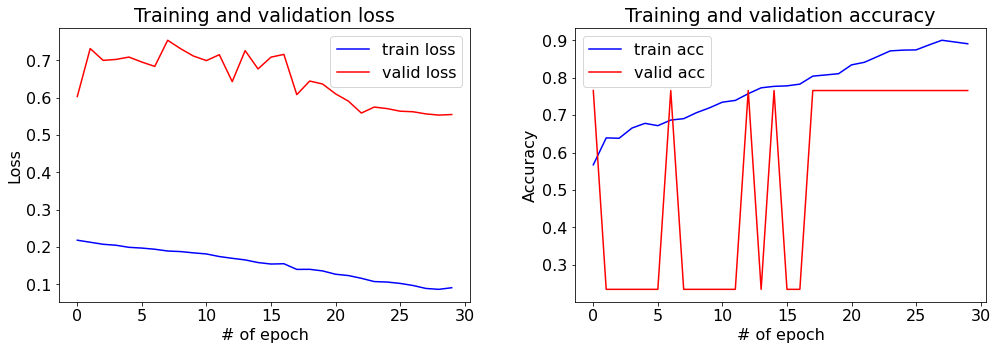

In [84]:
history_3_df = pd.read_pickle('history_3_df.pkl')
plot_history(history_3_df)

In [15]:
with open('model_3.json', 'r') as json_file:
    model_3 = json_file.read()

model_3 = model_from_json(model_3)
model_3.load_weights('xray_class_model_3.best.hdf5')

In [16]:
pred_Y_3 = model_3.predict_generator(test_gen, steps=len(test_df)/64, verbose = True)
np.save("pred_Y_3.npy", pred_Y_3)
np.save("ground_truth_3.npy", test_gen.labels)

351/350 [==============================] - 379s 1s/step


In [74]:
pred_Y_3 = np.load("pred_Y_3.npy")
ground_truth_3 = np.load("ground_truth_3.npy")
GT_pred_Y_3_df = make_GT_pred_df(ground_truth_3, pred_Y_3)
GT_pred_Y_3_df.to_pickle("GT_pred_Y_3_df.pkl")

,Ground_truth,Pred
0,0,0.289616
1,0,0.289354
2,0,0.292085
3,0,0.292913
4,0,0.292490


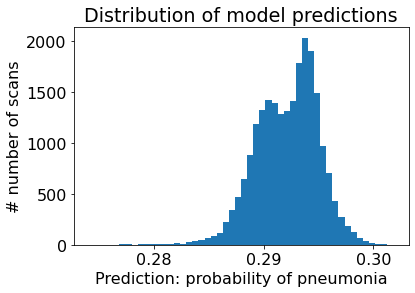

Model prediction min: 0.274
Model prediction max: 0.302


In [75]:
plot_prediction_distribution(pred_Y_3)

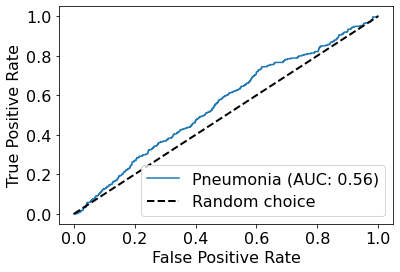

In [76]:
fpr_3, tpr_3, thresholds_auroc_3 = plot_AUROC(ground_truth_3, pred_Y_3)

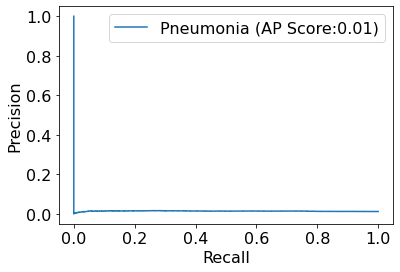

In [77]:
precision_3, recall_3, thresholds_pr_3 = plot_precision_recall_curve(ground_truth_3, pred_Y_3)

### Model 4 (ResNet50-based)

- Lowering the learning rate

In [51]:
weight_path_4 ="{}_model_4.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_4, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

model_4_pretrained = load_pretrained_model(pretrained_model=ResNet50, transfer_layer='conv5_block2_2_conv', transfer_layer_idx=158)
model_4 = build_model(model_4_pretrained, lr=1e-4)

Pre-trained model layers and their trainability
input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn Fa

In [52]:
history_4 = model_4.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

history_4_df = pd.DataFrame(history_4.history)
history_4_df.to_pickle('history_4_df.pkl')

model_4_json = model_4.to_json()
with open("model_4.json", "w") as json_file:
    json_file.write(model_4_json)

  ...
    to  
  ['...']
Train for 84 steps, validate on 64 samples
Epoch 1/30
83/84 [============================>.] - ETA: 1s - loss: 0.2216 - binary_accuracy: 0.7240
Epoch 00001: loss improved from inf to 0.22158, saving model to xray_class_model_4.best.hdf5
84/84 [==============================] - 151s 2s/step - loss: 0.2220 - binary_accuracy: 0.7243 - val_loss: 0.6918 - val_binary_accuracy: 0.7656
Epoch 2/30
83/84 [============================>.] - ETA: 1s - loss: 0.2194 - binary_accuracy: 0.7094
Epoch 00002: loss improved from 0.22158 to 0.21891, saving model to xray_class_model_4.best.hdf5
84/84 [==============================] - 146s 2s/step - loss: 0.2194 - binary_accuracy: 0.7075 - val_loss: 0.6974 - val_binary_accuracy: 0.2344
Epoch 3/30
83/84 [============================>.] - ETA: 1s - loss: 0.2145 - binary_accuracy: 0.6267
Epoch 00003: loss improved from 0.21891 to 0.21358, saving model to xray_class_model_4.best.hdf5
84/84 [==============================] - 145s 2s/step 

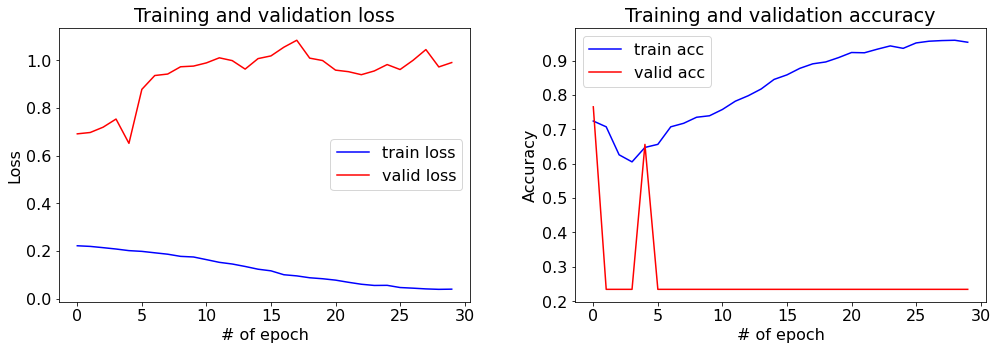

In [85]:
history_4_df = pd.read_pickle('history_4_df.pkl')
plot_history(history_4_df)

In [18]:
with open('model_4.json', 'r') as json_file:
    model_4 = json_file.read()

model_4 = model_from_json(model_4)
model_4.load_weights('xray_class_model_4.best.hdf5')

In [19]:
pred_Y_4 = model_4.predict_generator(test_gen, steps=len(test_df)/64, verbose = True)
np.save("pred_Y_4.npy", pred_Y_4)
np.save("ground_truth_4.npy", test_gen.labels)

351/350 [==============================] - 391s 1s/step


In [80]:
pred_Y_4 = np.load("pred_Y_4.npy")
ground_truth_4 = np.load("ground_truth_4.npy")
GT_pred_Y_4_df = make_GT_pred_df(ground_truth_4, pred_Y_4)
GT_pred_Y_4_df.to_pickle("GT_pred_Y_4_df.pkl")

,Ground_truth,Pred
0,0,0.683679
1,0,0.684824
2,0,0.684911
3,0,0.683658
4,0,0.683510


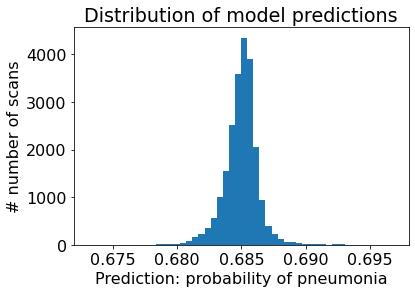

Model prediction min: 0.673
Model prediction max: 0.697


In [81]:
plot_prediction_distribution(pred_Y_4)

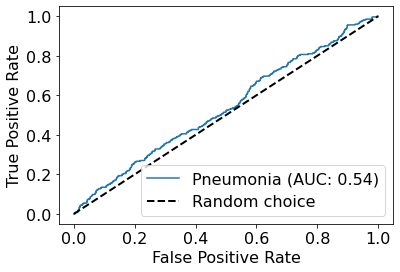

In [82]:
fpr_4, tpr_4, thresholds_auroc_4 = plot_AUROC(ground_truth_4, pred_Y_4)

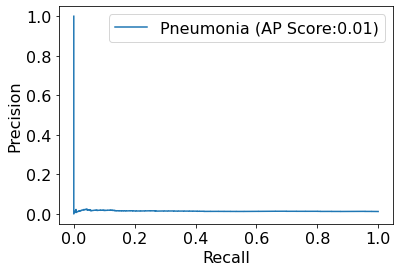

In [83]:
precision_4, recall_4, thresholds_pr_4 = plot_precision_recall_curve(ground_truth_4, pred_Y_4)

### Choice of best model for further evaluation

- Model 2 was chosen for further evaluation, as it features the highest AUC and AP score

In [87]:
# Choosing a threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision_2 - precision_value)).argmin() 
print('Precision is: '+ str(precision_2[idx]))
print('Recall is: '+ str(recall_2[idx]))
print('Threshold is: '+ str(thresholds_pr_2[idx]))
print('F1 Score is: ' + str(calc_f1(precision_2[idx],recall_2[idx])))

Precision is: 1.0
Recall is: 0.0036496350364963502
Threshold is: 0.104096465
F1 Score is: 0.007272727272727273


In [88]:
# Choosing a threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall_2 - recall_value)).argmin() 
print('Precision is: '+ str(precision_2[idx]))
print('Recall is: '+ str(recall_2[idx]))
print('Threshold is: '+ str(thresholds_pr_2[idx]))
print('F1 Score is: ' + str(calc_f1(precision_2[idx],recall_2[idx])))

Precision is: 0.013223040695568167
Recall is: 0.7992700729927007
Threshold is: 0.085829206
F1 Score is: 0.02601568068424804


- Treshold favouring higher F1-score will be chosen, i.e. 0.08

In [92]:
GT_pred_Y_2_tresh_df = GT_pred_Y_2_df
GT_pred_Y_2_tresh_df["tresh_pred"] = GT_pred_Y_2_tresh_df['Pred'] >= 0.0858
GT_pred_Y_2_tresh_df["tresh_pred"] = GT_pred_Y_2_tresh_df["tresh_pred"].replace(True, 1).replace(False, 0)
GT_pred_Y_2_tresh_df.head()

,Ground_truth,Pred,tresh_pred
0,0,0.083591,0.0
1,0,0.083884,0.0
2,0,0.090737,1.0
3,0,0.090424,1.0
4,0,0.090008,1.0


In [94]:
print(confusion_matrix(GT_pred_Y_2_tresh_df["Ground_truth"], GT_pred_Y_2_tresh_df["tresh_pred"]))

[[ 5775 16381]
 [   54   220]]


In [96]:
print(accuracy_score(GT_pred_Y_2_tresh_df["Ground_truth"], GT_pred_Y_2_tresh_df["tresh_pred"]))

0.2672759696834597
